In [ ]:
# CS444 U-Net Project Setup for Semantic Segmentation
# Attention U-Net on Cityscapes dataset and Summary Notebook

# Step 1: Install Required Libraries
!pip install torch torchvision --force-reinstall
!pip install segmentation-models-pytorch
!pip install matplotlib # Ensure matplotlib is installed for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.9 MB/s eta 0:00:00


In [ ]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 3: Verify Dataset Structure
import os

# Update this path to your specific Google Drive location for the Cityscapes dataset
root_path = '/content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes'

if not (os.path.exists(os.path.join(root_path, 'leftImg8bit')) and os.path.exists(os.path.join(root_path, 'gtFine'))):
    raise RuntimeError(f"Ensure 'leftImg8bit' and 'gtFine' folders are in the root directory: {root_path}. Please verify the path.")
else:
    print(f"Dataset structure verified: 'leftImg8bit' and 'gtFine' found in {root_path}.")

Dataset structure verified: 'leftImg8bit' and 'gtFine' found in /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes.


In [ ]:
# Step 4: Verify GPU Environment
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU detected. Training will run on CPU, which will be very slow. Ensure GPU runtime is enabled in Colab (Runtime > Change runtime type).")
    device = torch.device("cpu")

# Set environment variables for CUDA debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Synchronous CUDA errors
os.environ["TORCH_USE_CUDA_DSA"] = "1"    # Device-side assertions

PyTorch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
GPU device: NVIDIA L4


In [ ]:
# Step 5: Load Cityscapes Dataset
from torchvision.datasets import Cityscapes
from torchvision import transforms
import numpy as np
from PIL import Image # Needed for target resize resampling

# Define transforms (resize to manage memory)
# Original image size for Cityscapes is 1024x2048. Resizing significantly.
img_height, img_width = 128, 256 # Reduced size for faster training and lower memory

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

def target_to_tensor(target):
    # Resize target segmentation map. PIL Image object is expected by Resize.
    target = target.resize((img_width, img_height), resample=Image.NEAREST) # Nearest neighbor for labels
    target_np = np.array(target, dtype=np.uint8)

    # Map Cityscapes labels to 0-18 (for 19 classes), set others to ignore_index (255)
    label_map = {
        # name: id, trainId
        'unlabeled': (0, 255), 'ego vehicle': (1, 255), 'rectification border': (2, 255),
        'out of roi': (3, 255), 'static': (4, 255), 'dynamic': (5, 255),
        'ground': (6, 255), 'road': (7, 0), 'sidewalk': (8, 1),
        'parking': (9, 255), 'rail track': (10, 255), 'building': (11, 2),
        'wall': (12, 3), 'fence': (13, 4), 'guard rail': (14, 255),
        'bridge': (15, 255), 'tunnel': (16, 255), 'pole': (17, 5),
        'polegroup': (18, 255), 'traffic light': (19, 6), 'traffic sign': (20, 7),
        'vegetation': (21, 8), 'terrain': (22, 9), 'sky': (23, 10),
        'person': (24, 11), 'rider': (25, 12), 'car': (26, 13),
        'truck': (27, 14), 'bus': (28, 15), 'caravan': (29, 255),
        'trailer': (30, 255), 'train': (31, 16), 'motorcycle': (32, 17),
        'bicycle': (33, 18)
    }
    mapped_target = np.full_like(target_np, 255, dtype=np.uint8) # 255 for ignore_index

    for cityscapes_id_tuple, train_id in label_map.items():
        original_id = train_id[0]
        target_train_id = train_id[1]
        if target_train_id != 255:
            mapped_target[target_np == original_id] = target_train_id

    return torch.from_numpy(mapped_target).long()

# Load training and validation datasets
try:
    train_dataset = Cityscapes(
        root=root_path,
        split='train',
        mode='fine',
        target_type='semantic',
        transform=transform,
        target_transform=target_to_tensor
    )
    val_dataset = Cityscapes(
        root=root_path,
        split='val',
        mode='fine',
        target_type='semantic',
        transform=transform,
        target_transform=target_to_tensor
    )
    print(f"Successfully loaded train dataset with {len(train_dataset)} samples.")
    print(f"Successfully loaded val dataset with {len(val_dataset)} samples.")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure your `root_path` is correct and the dataset is properly structured.")
    raise

# Verify dataset labels from a sample
if len(train_dataset) > 0:
    sample_image, sample_target = train_dataset[0]
    print(f"Sample image shape: {sample_image.shape}")
    print(f"Sample target shape: {sample_target.shape}")
    unique_labels = torch.unique(sample_target)
    print(f"Sample target unique values: {unique_labels}")
    if not (all( (unique_labels >= 0) & (unique_labels <= 18) | (unique_labels == 255) )):
        print("Warning: Unexpected label values found in sample target.")
else:
    print("Train dataset is empty. Cannot verify sample.")

Successfully loaded train dataset with 2975 samples.
Successfully loaded val dataset with 500 samples.
Sample image shape: torch.Size([3, 128, 256])
Sample target shape: torch.Size([128, 256])
Sample target unique values: tensor([  0,   1,   2,   5,   7,   8,   9,  10,  11,  13,  18, 255])


In [ ]:
# Step 5.1: Verify Dataset Integrity (Optional, can be time-consuming for large datasets)
def check_dataset_integrity(dataset, split_name, num_samples_to_check=5):
    print(f"Checking {split_name} dataset integrity (first {num_samples_to_check} samples)...")
    if len(dataset) == 0:
        print(f"{split_name} dataset is empty. Skipping integrity check.")
        return True
    for i in range(min(num_samples_to_check, len(dataset))):
        try:
            image, target = dataset[i]
            # Basic checks
            if not isinstance(image, torch.Tensor) or not isinstance(target, torch.Tensor):
                print(f"Error at index {i}: Image or target is not a tensor.")
                return False
            if image.shape != torch.Size([3, img_height, img_width]):
                 print(f"Error at index {i}: Unexpected image shape {image.shape}.")
                 return False
            if target.shape != torch.Size([img_height, img_width]):
                 print(f"Error at index {i}: Unexpected target shape {target.shape}.")
                 return False
            if not ((target >= 0) & (target <= 18) | (target == 255)).all():
                 print(f"Error at index {i}: Target contains invalid labels {torch.unique(target)}.")
                 return False

        except Exception as e:
            print(f"Error accessing sample {i} in {split_name} dataset: {e}")
            return False
    print(f"{split_name} dataset integrity verified for first {num_samples_to_check} samples.")
    return True

# Check train and validation datasets (first few samples)
if not check_dataset_integrity(train_dataset, "train"):
    raise RuntimeError("Train dataset integrity check failed.")
if not check_dataset_integrity(val_dataset, "val"):
    raise RuntimeError("Validation dataset integrity check failed.")

Checking train dataset integrity (first 5 samples)...
train dataset integrity verified for first 5 samples.
Checking val dataset integrity (first 5 samples)...
val dataset integrity verified for first 5 samples.


In [ ]:
# Step 6: Create Data Loaders
from torch.utils.data import DataLoader

batch_size = 2

if len(train_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
else:
    train_loader = None
    print("Train dataset is empty. Train loader not created.")

if len(val_dataset) > 0:
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
else:
    val_loader = None
    print("Validation dataset is empty. Validation loader not created.")

if train_loader:
    print(f"Train loader created with batch size {batch_size}.")
if val_loader:
    print(f"Validation loader created with batch size {batch_size}.")

Train loader created with batch size 2.
Validation loader created with batch size 2.


In [ ]:
# Step 7: Define Models
import segmentation_models_pytorch as smp

num_classes = 19  # Based on the label mapping (0-18)
encoder_name = "resnet34"

# Attention U-Net (with SCSE attention)
model_attention = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
    activation=None,
    decoder_attention_type="scse" # Spatial and Channel Squeeze & Excitation
)
print(f"Attention U-Net (SCSE) with {encoder_name} encoder defined.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Standard U-Net with resnet34 encoder defined.
Attention U-Net (SCSE) with resnet34 encoder defined.
U-Net++ with resnet34 encoder defined.


In [ ]:
# Step 8: Define Loss Function
import torch.nn as nn
# CrossEntropyLoss expects raw logits from the model and long type targets.
# ignore_index=255 means that pixels with label 255 will not contribute to the loss.
criterion = nn.CrossEntropyLoss(ignore_index=255)
print("CrossEntropyLoss defined with ignore_index=255.")

CrossEntropyLoss defined with ignore_index=255.


In [ ]:
# Step 8.1: Setup Model Saving and Validation Loss Function
import os

save_dir = os.path.join(root_path, 'saved_models')
os.makedirs(save_dir, exist_ok=True)
print(f"Models will be saved in: {save_dir}")

def evaluate_validation_loss(model, loader, criterion, device, model_name):
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    num_batches = len(loader)

    if num_batches == 0:
        print(f"Warning: Validation loader for {model_name} is empty. Cannot compute validation loss.")
        return float('inf') # Return infinity if no validation can be done

    with torch.no_grad(): # No gradients needed for validation
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)

            # Ensure targets are valid before calculating loss
            if not ((targets >= 0) & (targets < num_classes) | (targets == 255)).all():
                print(f"Validation: Invalid labels detected in targets for {model_name}! Unique: {torch.unique(targets)}. Skipping batch for loss calculation.")
                pass

            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / num_batches if num_batches > 0 else float('inf')
    if device.type == "cuda":
        torch.cuda.empty_cache()
    return avg_val_loss

Models will be saved in: /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes/saved_models


In [ ]:
# Step 9: Training Configuration
num_epochs = 15 # Increased number of epochs
learning_rate = 0.001
weight_decay = 1e-5 # Added weight decay for regularization

# Helper function for training one epoch
def train_one_epoch(model, loader, optimizer, criterion, device, model_name):
    model.train()
    running_loss = 0.0
    num_batches = len(loader)

    if num_batches == 0:
        print(f"Warning: Training loader for {model_name} is empty. Skipping training epoch.")
        return 0.0

    for i, (images, targets) in enumerate(loader):
        images, targets = images.to(device), targets.to(device)

        try:
            # Verify target labels before passing to model/loss
            if not ((targets >= 0) & (targets < num_classes) | (targets == 255)).all():
                print(f"Batch {i}: Invalid labels detected in targets for {model_name}! Unique: {torch.unique(targets)}. Skipping batch.")
                problematic_targets = targets.clone()
                problematic_targets[(targets >= 0) & (targets < num_classes) | (targets == 255)] = -1 # Mark valid ones
                print(f"Problematic target values: {torch.unique(problematic_targets.masked_select(problematic_targets != -1))}")
                continue # Skip this batch

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i + 1) % (num_batches // 5 if num_batches >= 5 else 1) == 0: # Print 5 times per epoch
                print(f"    {model_name} - Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}")

        except RuntimeError as e:
            print(f"RuntimeError during training {model_name} at batch {i}: {e}")
            if "CUDA out of memory" in str(e):
                print("CUDA OOM: Try reducing batch size or image dimensions.")
                if device.type == "cuda": torch.cuda.empty_cache()
            return float('inf') # Indicate critical error

    epoch_loss = running_loss / num_batches if num_batches > 0 else 0
    if device.type == "cuda":
        torch.cuda.empty_cache()
    return epoch_loss

In [ ]:
# --- Training Cell 9.2: Attention U-Net ---
print(f"\n--- Training Attention U-Net (SCSE, {encoder_name}) ---")
model_name_attention = "attention_unet_scse"
best_model_attention_path = os.path.join(save_dir, f"{model_name_attention}_best_val.pth")
final_model_attention_path = os.path.join(save_dir, f"{model_name_attention}_final_epoch.pth")
best_val_loss_attention = float('inf')

if train_loader:
    model_attention.to(device)
    # Initialize optimizer with weight decay
    optimizer_attention = torch.optim.Adam(model_attention.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Initialize learning rate scheduler
    scheduler_attention = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_attention, mode='min', factor=0.1, patience=5, verbose=True) # Adjust patience as needed

    if device.type == "cuda":
        torch.cuda.empty_cache()
        print(f"Initial GPU memory allocated for Attention U-Net: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Training phase
        epoch_loss_attention = train_one_epoch(model_attention, train_loader, optimizer_attention, criterion, device, "Attention U-Net")
        if epoch_loss_attention == float('inf'):
            print(f"Critical error training Attention U-Net in epoch {epoch+1}. Stopping training for this model.")
            break
        print(f"  Attention U-Net - Epoch {epoch+1} Average Training Loss: {epoch_loss_attention:.4f}")

        # Validation phase
        if val_loader:
            current_val_loss = evaluate_validation_loss(model_attention, val_loader, criterion, device, "Attention U-Net (Validation)")
            print(f"  Attention U-Net - Epoch {epoch+1} Average Validation Loss: {current_val_loss:.4f}")

            if current_val_loss < best_val_loss_attention:
                best_val_loss_attention = current_val_loss
                torch.save(model_attention.state_dict(), best_model_attention_path)
                print(f"    New best model saved to {best_model_attention_path} (Val Loss: {current_val_loss:.4f})")

            # Step the learning rate scheduler based on validation loss
            scheduler_attention.step(current_val_loss)
        else:
            print("  Skipping validation for checkpointing and LR scheduling as val_loader is not available.")

    # Save the final model state
    torch.save(model_attention.state_dict(), final_model_attention_path)
    print(f"--- Attention U-Net Training Finished. Final model saved to {final_model_attention_path} ---")
    if val_loader and os.path.exists(best_model_attention_path):
        print(f"Best validation model saved at {best_model_attention_path} with val_loss: {best_val_loss_attention:.4f}")
else:
    print("Skipping Attention U-Net training as train_loader is not available.")


--- Training Attention U-Net (SCSE, resnet34) ---
Initial GPU memory allocated for Attention U-Net: 94.98 MB
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  if isinstance(param, (list, tuple)):


    Attention U-Net - Batch 297/1488, Loss: 0.7388
    Attention U-Net - Batch 594/1488, Loss: 0.6324
    Attention U-Net - Batch 891/1488, Loss: 0.4221
    Attention U-Net - Batch 1188/1488, Loss: 0.5033
    Attention U-Net - Batch 1485/1488, Loss: 0.6730
  Attention U-Net - Epoch 1 Average Training Loss: 0.7013
  Attention U-Net - Epoch 1 Average Validation Loss: 0.6897
    New best model saved to /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes/saved_models/attention_unet_scse_best_val.pth (Val Loss: 0.6897)
Epoch 2/15
    Attention U-Net - Batch 297/1488, Loss: 0.7954
    Attention U-Net - Batch 594/1488, Loss: 0.4459
    Attention U-Net - Batch 891/1488, Loss: 0.4339
    Attention U-Net - Batch 1188/1488, Loss: 0.5174
    Attention U-Net - Batch 1485/1488, Loss: 0.7116
  Attention U-Net - Epoch 2 Average Training Loss: 0.5321
  Attention U-Net - Epoch 2 Average Validation Loss: 0.5498
    New best model saved to /content/drive/MyDrive/Colab Notebo

In [ ]:
# --- Training Cell 9.2.1: Fine-tune Attention U-Net ---
print(f"\n--- Fine-tuning Attention U-Net (SCSE, {encoder_name}) ---")

# Define parameters for fine-tuning
num_ft_epochs = 5
fine_tune_lr = 5e-5

# Paths for the fine-tuned model
model_name_attention_ft = "attention_unet_scse_ft"
best_model_attention_ft_path = os.path.join(save_dir, f"{model_name_attention_ft}_best_val.pth")
final_model_attention_ft_path = os.path.join(save_dir, f"{model_name_attention_ft}_final_epoch.pth")

pretrained_model_path = os.path.join(save_dir, "attention_unet_scse_best_val.pth")

best_val_loss_attention_ft = 0.4018

if not os.path.exists(pretrained_model_path):
    print(f"Error: Pretrained model not found at {pretrained_model_path}. Cannot fine-tune.")
    print("Please ensure the initial training (Cell 9.2) was run and the best model was saved correctly.")
else:
    if train_loader and val_loader:
        if 'model_attention' not in globals() or model_attention is None:
            print("Re-defining Attention U-Net model architecture for fine-tuning...")
            model_attention = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights=None,
                in_channels=3,
                classes=num_classes,
                activation=None,
                decoder_attention_type="scse"
            )
            print("Attention U-Net model re-defined.")
        else:
            print("Using existing 'model_attention' instance.")


        print(f"Loading weights from {pretrained_model_path} for fine-tuning...")
        try:
            model_attention.load_state_dict(torch.load(pretrained_model_path, map_location=device))
            print("Successfully loaded pre-trained weights.")
        except Exception as e:
            print(f"Error loading pre-trained weights: {e}")
            raise

        model_attention.to(device)

        # Initialize a new optimizer with the fine-tuning learning rate
        optimizer_attention_ft = torch.optim.Adam(model_attention.parameters(), lr=fine_tune_lr, weight_decay=weight_decay)

        # Initialize a new learning rate scheduler for fine-tuning
        scheduler_attention_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_attention_ft, mode='min', factor=0.1, patience=3)

        if device.type == "cuda":
            torch.cuda.empty_cache()
            print(f"Initial GPU memory allocated for Fine-tuning Attention U-Net: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

        print(f"Starting fine-tuning for {num_ft_epochs} epochs with LR: {fine_tune_lr}")
        for epoch in range(num_ft_epochs):
            current_epoch_ft = epoch + 1 # For display
            print(f"Fine-tuning Epoch {current_epoch_ft}/{num_ft_epochs}. Current LR: {optimizer_attention_ft.param_groups[0]['lr']:.2e}") # Display current LR

            # Training phase
            epoch_loss_attention_ft = train_one_epoch(model_attention, train_loader, optimizer_attention_ft, criterion, device, "Attention U-Net (Fine-tuning)")
            if epoch_loss_attention_ft == float('inf'):
                print(f"Critical error fine-tuning Attention U-Net in epoch {current_epoch_ft}. Stopping fine-tuning.")
                break
            print(f"  Attention U-Net (Fine-tuning) - Epoch {current_epoch_ft} Average Training Loss: {epoch_loss_attention_ft:.4f}")

            # Validation phase
            current_val_loss_ft = evaluate_validation_loss(model_attention, val_loader, criterion, device, "Attention U-Net (Fine-tuning Validation)")
            print(f"  Attention U-Net (Fine-tuning) - Epoch {current_epoch_ft} Average Validation Loss: {current_val_loss_ft:.4f}")

            if current_val_loss_ft < best_val_loss_attention_ft:
                best_val_loss_attention_ft = current_val_loss_ft
                torch.save(model_attention.state_dict(), best_model_attention_ft_path)
                print(f"    New best fine-tuned model saved to {best_model_attention_ft_path} (Val Loss: {current_val_loss_ft:.4f})")

            # Step the learning rate scheduler
            scheduler_attention_ft.step(current_val_loss_ft)

        # Save the final model state after fine-tuning
        torch.save(model_attention.state_dict(), final_model_attention_ft_path)
        print(f"--- Attention U-Net Fine-tuning Finished. Final model saved to {final_model_attention_ft_path} ---")
        if os.path.exists(best_model_attention_ft_path):
            print(f"Best fine-tuned validation model saved at {best_model_attention_ft_path} with val_loss: {best_val_loss_attention_ft:.4f}")
    else:
        if not train_loader: print("Skipping fine-tuning as train_loader is not available.")
        if not val_loader: print("Skipping fine-tuning as val_loader is not available (validation is crucial for fine-tuning).")


--- Fine-tuning Attention U-Net (SCSE, resnet34) ---
Using existing 'model_attention' instance.
Loading weights from /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes/saved_models/attention_unet_scse_best_val.pth for fine-tuning...
Successfully loaded pre-trained weights.
Initial GPU memory allocated for Fine-tuning Attention U-Net: 94.98 MB
Starting fine-tuning for 5 epochs with LR: 5e-05
Fine-tuning Epoch 1/5. Current LR: 5.00e-05
    Attention U-Net (Fine-tuning) - Batch 297/1488, Loss: 0.2207
    Attention U-Net (Fine-tuning) - Batch 594/1488, Loss: 0.1916
    Attention U-Net (Fine-tuning) - Batch 891/1488, Loss: 0.2377
    Attention U-Net (Fine-tuning) - Batch 1188/1488, Loss: 0.3385
    Attention U-Net (Fine-tuning) - Batch 1485/1488, Loss: 0.3231
  Attention U-Net (Fine-tuning) - Epoch 1 Average Training Loss: 0.2736
  Attention U-Net (Fine-tuning) - Epoch 1 Average Validation Loss: 0.3570
    New best fine-tuned model saved to /content/drive/My

In [ ]:
# Step 10: Evaluation Function for IoU
def compute_iou(outputs, targets, num_classes, ignore_index=255):
    outputs = torch.argmax(outputs, dim=1) # Get predicted class for each pixel

    outputs = outputs.cpu()
    targets = targets.cpu()

    iou_per_class = []
    for cls in range(num_classes): # Iterate from 0 to num_classes-1
        pred_inds = (outputs == cls)
        target_inds = (targets == cls)

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)

    # Calculate mean IoU, ignoring NaN values (classes not present in this batch)
    valid_iou = [iou for iou in iou_per_class if not np.isnan(iou)]
    mean_iou_batch = np.nanmean(valid_iou) if len(valid_iou) > 0 else float('nan')

    return mean_iou_batch, iou_per_class

In [ ]:
# Step 11: Evaluate Models on Validation Set (Handling Specific Filenames)
print("\n--- Evaluating Models on Validation Set (Prioritizing Fine-Tuned) ---")

model_configurations = [
    {
        "name": "Standard U-Net (ResNet34)",
        "model_class": smp.Unet,
        "params": {
            "encoder_name": "resnet34",
            "encoder_weights": None,
            "in_channels": 3,
            "classes": num_classes,
            "activation": None
        },
        "save_name_prefix": "standard_unet", # For constructing standard_unet_best_val.pth etc.
        "instance": None
    },
    {
        "name": "Attention U-Net (ResNet34)",
        "model_class": smp.Unet,
        "params": {
            "encoder_name": "resnet34",
            "encoder_weights": None,
            "in_channels": 3,
            "classes": num_classes,
            "activation": None,
            "decoder_attention_type": "scse"
        },
        "save_name_prefix": "attention_unet_scse", # For attention_unet_scse_best_val.pth etc.
        "instance": None
    },
    {
        "name": "U-Net++ (ResNet34)",
        "model_class": smp.UnetPlusPlus,
        "params": {
            "encoder_name": "resnet34",
            "encoder_weights": None,
            "in_channels": 3,
            "classes": num_classes,
            "activation": None
        },
        "save_name_prefix": "unetplusplus", # For unetplusplus_best_val.pth etc.
        "instance": None
    },
    {
        "name": "Attention U-Net (MobileNetV2 FT)",
        "model_class": smp.Unet,
        "params": {
            "encoder_name": "mobilenet_v2",
            "encoder_weights": None,
            "in_channels": 3,
            "classes": num_classes,
            "activation": None,
            "decoder_attention_type": "scse"
        },
        "exact_filename_on_disk": "attention_unet_scse_ft_best_val_mobilenetv2.pth",
        "instance": None
    },
    {
        "name": "Attention U-Net (ResNet50 FT)",
        "model_class": smp.Unet,
        "params": {
            "encoder_name": "resnet50",
            "encoder_weights": None,
            "in_channels": 3,
            "classes": num_classes,
            "activation": None,
            "decoder_attention_type": "scse"
        },
        "exact_filename_on_disk": "attention_unet_scse_ft_best_val_resnet50.pth",
        "instance": None
    }
]

if val_loader:
    for config_idx, config in enumerate(model_configurations):
        base_model_name = config["name"]
        actual_model_path_to_load = None

        if "exact_filename_on_disk" in config:
            exact_path = os.path.join(save_dir, config["exact_filename_on_disk"])
            print(f"\n--- Evaluating: {base_model_name} ---")
            if os.path.exists(exact_path):
                actual_model_path_to_load = exact_path
                print(f"Attempting to load exact specified model file: {actual_model_path_to_load}")
            else:
                print(f"Specified exact model file not found: {exact_path}")
                model_configurations[config_idx]["instance"] = None
                continue
        else:
            prefix = config["save_name_prefix"]
            model_path_ft = os.path.join(save_dir, f"{prefix}_ft_best_val.pth")
            model_path_orig = os.path.join(save_dir, f"{prefix}_best_val.pth")

            if os.path.exists(model_path_ft):
                actual_model_path_to_load = model_path_ft
                base_model_name = f"{config['name']} (Fine-tuned)"
                print(f"\n--- Evaluating: {base_model_name} ---")
                print(f"Found fine-tuned model. Loading from: {actual_model_path_to_load}")
            elif os.path.exists(model_path_orig):
                actual_model_path_to_load = model_path_orig
                base_model_name = f"{config['name']} (Original Best)"
                print(f"\n--- Evaluating: {base_model_name} ---")
                print(f"Fine-tuned model not found. Loading original best model from: {actual_model_path_to_load}")
            else:
                print(f"\n--- Skipping: {config['name']} ---")
                print(f"Saved model not found (neither original nor fine-tuned via prefix '{prefix}').")
                print(f"  Checked paths: {model_path_ft} (FT) and {model_path_orig} (Orig)")
                model_configurations[config_idx]["instance"] = None
                continue

        model = config["model_class"](**config["params"])

        try:
            model.load_state_dict(torch.load(actual_model_path_to_load, map_location=device))
            model.to(device)
            model.eval()
            model_configurations[config_idx]["instance"] = model
            model_configurations[config_idx]["loaded_name"] = base_model_name
            print(f"Successfully loaded model: {base_model_name}")
        except Exception as e:
            print(f"Error loading model {base_model_name} from {actual_model_path_to_load}: {e}")
            model_configurations[config_idx]["instance"] = None
            continue

        # --- Evaluation Loop ---
        all_mean_ious_current_model, all_class_ious_current_model = [], []
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(val_loader):
                if batch_idx % (len(val_loader) // 2 + 1) == 0:
                    print(f"  {base_model_name} - Evaluating batch {batch_idx+1}/{len(val_loader)}")
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                mean_iou_batch, class_iou_batch = compute_iou(outputs, targets, num_classes)

                if not np.isnan(mean_iou_batch):
                    all_mean_ious_current_model.append(mean_iou_batch)
                all_class_ious_current_model.append(class_iou_batch)

        if device.type == "cuda":
            torch.cuda.empty_cache()

        final_miou = np.nanmean(all_mean_ious_current_model) if all_mean_ious_current_model else float('nan')
        final_class_iou_array = np.array(all_class_ious_current_model)

        if final_class_iou_array.size > 0:
            final_class_iou = np.nanmean(final_class_iou_array, axis=0)
        else:
            final_class_iou = np.array([float('nan')] * num_classes)

        print(f"\nResults for {base_model_name}:")
        print(f"  Mean IoU: {final_miou:.4f}")

        person_idx = 11
        car_idx = 13

        if len(final_class_iou) > max(person_idx, car_idx):
            print(f"  Person (class {person_idx}) IoU: {final_class_iou[person_idx]:.4f}")
            print(f"  Car (class {car_idx}) IoU:    {final_class_iou[car_idx]:.4f}")
        else:
            print(f"  Class IoUs for Person/Car not available (expected {num_classes} classes, got {len(final_class_iou)}).")
else:
    print("Skipping evaluation as val_loader is not available.")


--- Evaluating Models on Validation Set (Prioritizing Fine-Tuned) ---

--- Evaluating: Standard U-Net (ResNet34) (Fine-tuned) ---
Found fine-tuned model. Loading from: /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes/saved_models/standard_unet_ft_best_val.pth
Successfully loaded model: Standard U-Net (ResNet34) (Fine-tuned)
  Standard U-Net (ResNet34) (Fine-tuned) - Evaluating batch 1/250
  Standard U-Net (ResNet34) (Fine-tuned) - Evaluating batch 127/250

Results for Standard U-Net (ResNet34) (Fine-tuned):
  Mean IoU: 0.3165
  Person (class 11) IoU: 0.2180
  Car (class 13) IoU:    0.6441

--- Evaluating: Attention U-Net (ResNet34) (Fine-tuned) ---
Found fine-tuned model. Loading from: /content/drive/MyDrive/Colab Notebooks/CS444/U-Net Segmentation Project/CityScapes/saved_models/attention_unet_scse_ft_best_val.pth
Successfully loaded model: Attention U-Net (ResNet34) (Fine-tuned)
  Attention U-Net (ResNet34) (Fine-tuned) - Evaluating batch 1/250
  At


--- Visualizing Predictions (Modularly) ---
Selected sample index 10 for visualization (contains person/car).


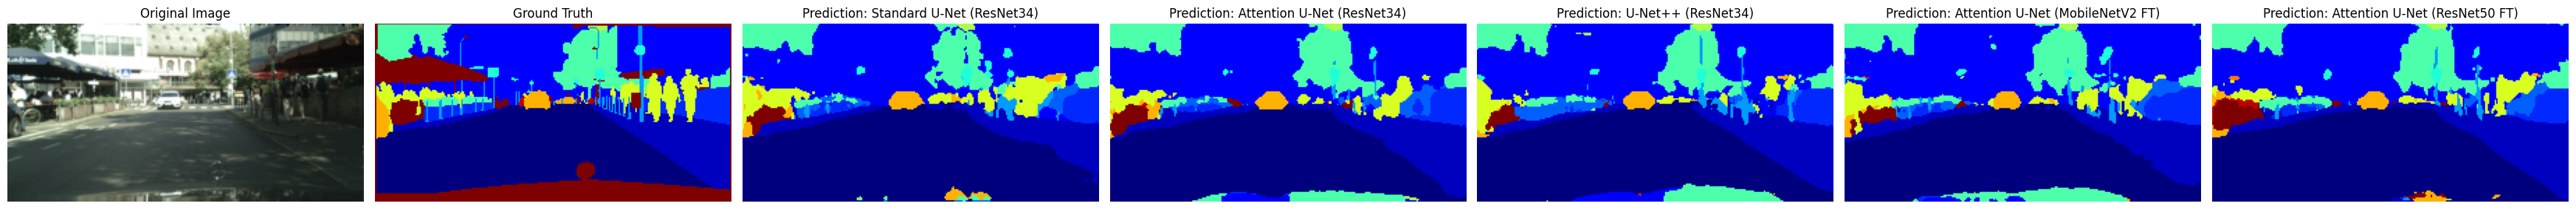


--- Modular Visualization Finished ---


In [ ]:
# Step 12: Visualize Predictions (Modularly)
import matplotlib.pyplot as plt # Ensure matplotlib is imported

def denormalize_image(tensor_image):
   img = tensor_image.cpu().numpy().transpose(1, 2, 0)
   return img

def visualize_predictions_modular(val_dataset, loaded_models_with_names, device, num_classes_vis):
    if val_dataset is None or len(val_dataset) == 0:
        print("Validation dataset not available for visualization.")
        return

    if not loaded_models_with_names: # Check if the list is empty
        print("No models were successfully loaded for visualization. Skipping.")
        return

    # --- Sample Selection Logic  ---
    sample_idx = 0
    try:
        candidate_indices = [10, 20, 30, 40, 50, 0, 5, 15]
        found_sample = False
        for idx in candidate_indices:
            if idx < len(val_dataset):
                _, target_gt_check = val_dataset[idx]
                # Check for person (11) or car (13)
                if torch.any(target_gt_check == 11) or torch.any(target_gt_check == 13):
                    sample_idx = idx
                    print(f"Selected sample index {sample_idx} for visualization (contains person/car).")
                    found_sample = True
                    break
        if not found_sample:
             sample_idx = min(0, len(val_dataset)-1) if len(val_dataset) > 0 else 0
             print(f"Using default sample index {sample_idx} for visualization.")

    except Exception as e:
        print(f"Error during sample selection, using default index 0. Error: {e}")
        sample_idx = 0

    if sample_idx >= len(val_dataset) and len(val_dataset) > 0:
        print(f"Sample index {sample_idx} is out of bounds. Using index 0.")
        sample_idx = 0
    elif len(val_dataset) == 0:
        print("Validation set is empty, cannot visualize.")
        return

    original_image, target_gt = val_dataset[sample_idx]
    image_tensor_vis = original_image.unsqueeze(0).to(device)
    target_gt_np_vis = target_gt.cpu().numpy()

    predictions_vis = []
    model_names_vis = []
    with torch.no_grad():
        for model_info in loaded_models_with_names:
            model_instance = model_info["instance"]
            model_name_vis = model_info["name"]

            model_instance.eval().to(device) # Ensure model is on device and in eval mode
            output = model_instance(image_tensor_vis)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            predictions_vis.append(pred_mask)
            model_names_vis.append(model_name_vis)

    num_plots = 1 + 1 + len(predictions_vis) # Original, Ground Truth, each loaded model prediction
    plt.figure(figsize=(5 * num_plots, 5))

    plt.subplot(1, num_plots, 1)
    plt.title("Original Image")
    plt.imshow(denormalize_image(original_image))
    plt.axis('off')

    plt.subplot(1, num_plots, 2)
    plt.title("Ground Truth")
    plt.imshow(target_gt_np_vis, cmap='jet', vmin=0, vmax=num_classes_vis-1)
    plt.axis('off')

    for i, (pred_mask, name) in enumerate(zip(predictions_vis, model_names_vis)):
        plt.subplot(1, num_plots, 3 + i)
        plt.title(f"Prediction: {name}")
        plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=num_classes_vis-1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if device.type == "cuda":
        torch.cuda.empty_cache()

# --- Call Visualization ---
print("\n--- Visualizing Predictions (Modularly) ---")

successfully_loaded_models_for_viz = []
for config in model_configurations:
    if config.get("instance") is not None:
        successfully_loaded_models_for_viz.append({
            "name": config["name"],
            "instance": config["instance"]
        })

if val_dataset and len(val_dataset) > 0:
    if successfully_loaded_models_for_viz:
        visualize_predictions_modular(
            val_dataset,
            loaded_models_with_names=successfully_loaded_models_for_viz,
            device=device,
            num_classes_vis=num_classes
        )
    else:
        print("No models were trained or loaded successfully in Step 11. Skipping visualization.")
else:
    print("Skipping visualization as validation dataset is not available.")

print("\n--- Modular Visualization Finished ---")